# Github Repository Scraper Project

#### Contributers Github Profiles:
- [Deangelo Bowen](https://github.com/DeangeloBowen1)
- [Kayla Brock](https://github.com/Kayfj41901)

---

## Project Deliverables:

- Indepth analysis on the NLP. 
- Summary of exploration and key takeaways. 
- Creating model(s) that can accurately predict the programming language used in a repository based on the READMe content.

---

## Project Overview and Objectives:

_For this project, we used data from GitHub repository README files. The goal was to build a model that can predict the programming language of a repository, given the text of the README file._

The Github repositories searched were those containing the use of the world 'Apple' in purusit of targeting apple based products and programs:

[Here is a link to the repositories we scrapped](https://github.com/search?q=apple)

### What we did:
- We scrapped the first 50 pages of the link posted above:
    - This returned ~480 repositories
    - We implemented a function that could go through each repository and return the README content and the most used language based on the data collected by GitHub. 
    - We proceededed to cleaning the data for an NLP in which we could be properly modeled upon.
    - We implemented different models to find which would return the best prediction on language based on key words found in the NLP exploration phase. 

---

## Exploration Summary:

During the exploration we identified the most frequent words per programming language.

#### Swift
`Style`, `IMG` , `Shield IO`, and `SRV & SVC`

#### JavaScript
`Open Source` , `Freeware` , `Software`
    

#### Objective-C
`HTML`, `Audio`, `Video` , `Integration`, `Graphic & Animation`

#### Python
`Python language was very case specific as none of the words defined pythonic language`

#### Java
`APP`, `SVG`, `REACT`, `Shield IO`

#### C
`Series`, `Trackpad`,`SRC`,`DRV`

#### Many of the languages key words overlap for two primary reasons:
- Swift, Objective-C, and C are all a part of the C programming langauge family, and as such they have many of the same terms used while in use.

---

## Executive Summary:

After scraping GitHub repositories  using the search engine filtering for the keyword 'Apple', we discovered the most frequent keywords used across 22 different programming languages. We then created a model designed around the top 6 most used languages in our sample data that could predict the use of those languages based on their keywords and features with 53% accuracy. 

We do believe that with more time and more sample data, we could create a more accurate model with properly conducted feature engineering. 

---

## Imports

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import explore as e
import prepare as p 
import modeling as m

import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

---

# Acquiring the Repositories

To acquire the repositories we created function that takes in a github repo webpage from 'search', iterates through the page numbers associated with that search (user input) and returns the user/repo_name associated with that search category.

In [2]:
def get_repos(n, use_cache = True):
    """function that takes in a github repo webpage from 'search',
    iterates through the page numbers associated with that search (user input) 
    and returns the user/repo_name associated with that search category"""
    
    all_repos = []
    for page in range(1, n):
        url = f'https://github.com/search?p={page}&q=apple&type=Repositories'
        headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}
        while True:
            response = get(url, headers=headers)
            if response.ok:
                break
            else:
                time.sleep(15)
        soup = BeautifulSoup(response.text, 'html.parser')
        repo = [a.text for a in soup.find_all('a', class_='v-align-middle')]
        all_repos.append(repo)
        print(f'\rFetching page {page} of {n-1} {url}', end='')
    return all_repos

After acquiring each repository name we implemented a multi-function process that got the `github api requests`, read the `github repository language`, read the `repository contents`, then `downloaded the readme url, processed the repository, and scrape the github data`.

---

## Preparing the Repositories

### To prepare the repo dataframe:

In [3]:
# call the json file
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,acidanthera/AppleALC,C++,AppleALC\n========\n\n[![Build Status](https:/...
1,gongjianhui/AppleDNS,Python,# Final AppleDNS Pro\n\nAppleDNS 通过收集 Apple 在中...
2,tomaz/appledoc,Objective-C,About appledoc\n==============\n\n**IMPORTANT ...
3,robovm/apple-ios-samples,Objective-C,# Mirror of Apple's iOS samples\n\nThis reposi...
4,appleseedhq/appleseed,C++,# appleseed [![Build Status](https://travis-ci...


In [4]:
# clean json and prepare for exploration
df = p.create_df(df)

In [5]:
# exploration dataframe
df.head()

,repo,language,original,lemmatized
0,acidanthera/AppleALC,C++,AppleALC\n========\n\n[![Build Status](https:/...,applealc acidanthera applealc workflow ci badg...
1,gongjianhui/AppleDNS,Python,# Final AppleDNS Pro\n\nAppleDNS 通过收集 Apple 在中...,final appledns pro appledns cdn itunes icloud ...
2,tomaz/appledoc,Objective-C,About appledoc\n==============\n\n**IMPORTANT ...,appledoc important notice collaborator needed ...
3,robovm/apple-ios-samples,Objective-C,# Mirror of Apple's iOS samples\n\nThis reposi...,mirror io sample repository mirror io sample l...
4,appleseedhq/appleseed,C++,# appleseed [![Build Status](https://travis-ci...,appleseed travis ci appleseedhq appleseed svg ...


#### Started with 490 values
- dropped null-identified languages
- Removed small sample sized languages identified such as, AppleScript, TypeScript, GO, HTML, CSS, etc.
- tokenized then lemmatized the readme samples
- removed stopwords, which involved appending `new_stopwords` for words we identified as irrelevant in the prediction of programming language (such as the excessive use of 'com' and 'www').

---

# Exploration

#### Before Exploration We:
- Identified our top 6 languages, which were the languages that were used the most frequent based on our search. 
- These languages were `Swift`, `JavaScript`, `Objective-C`, `Python`,`Java`, and `C`.
- created trigrams for each languages most used words
- Represented them each in a word cloud to and bar graph to discover what the most frequent languages were. 

In [6]:
# preparing dataframe for each programming language for individual exploration
swift, javascript, objective_c, python, java, c = e.top_6_languages()

In [7]:
# create top 25 trigrams for each programming language

#swift
swift_25 = e.create_trigram(swift)

#JavaScript
javascript_25 = e.create_trigram(javascript)

# Objective-C
objective_c_25 = e.create_trigram(objective_c)

# Python
python_25 = e.create_trigram(python)

# Java 
java_25 = e.create_trigram(java)

# C
c_25 = e.create_trigram(c)

---

### Visual Exploratory Analysis

_Each programming langauge's most frequent words were analyized bar chart and word cloud via trigram_ 

## Swift

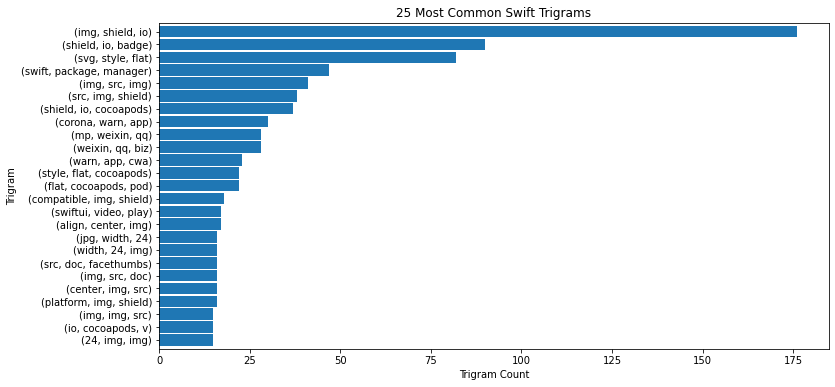

In [8]:
# barh graph of swift top trigrams
e.get_graph(swift_25, 'Swift')

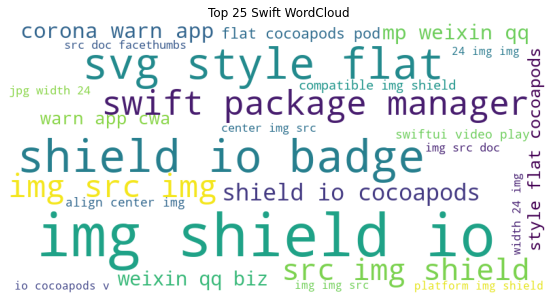

In [9]:
# word cloud of swift top trigrams
e.word_cloud(swift_25, 'Swift')

### Takeaways:

- `Style`, `img`, `shield io` is seen frequently in the top 25 trigrams for Swift programming language. 
- There is also the term `swift package`, `src`, `svc`, etc.
- The Swift compilers are mostly written in `C++`. So there is a high chance that the trigrams identified in Swift will be similar to `C based languages`

---

## JavaScript

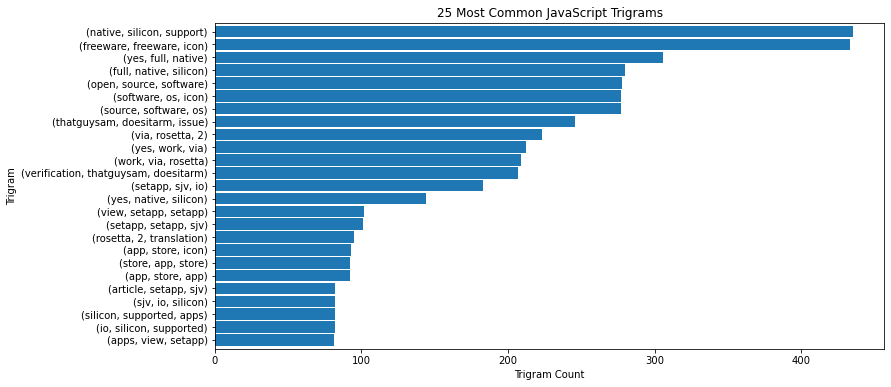

In [10]:
e.get_graph(javascript_25, 'JavaScript')

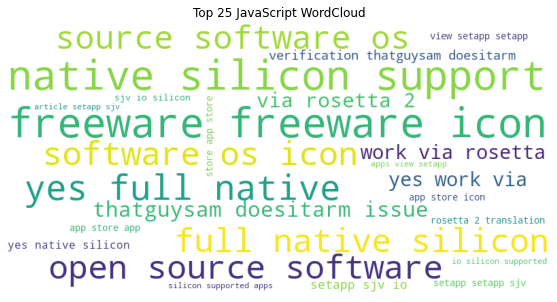

In [11]:
e.word_cloud(javascript_25, 'JavaScript')

### Takeaways:

- `Open`, `Source`, `Freeware`, and others could be good predictors of JavaScript
- Javascript is used by programmers across the world to create dynamic and interactive web content like applications and browsers. 
- This could mean that othe words like `software` and `native` could have a strong relationship to identifying Javascript

---

## Objective-C 

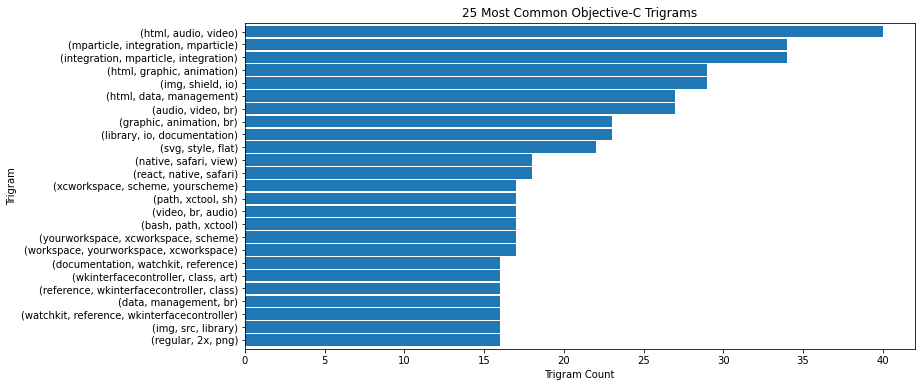

In [12]:
e.get_graph(objective_c_25, 'Objective-C')

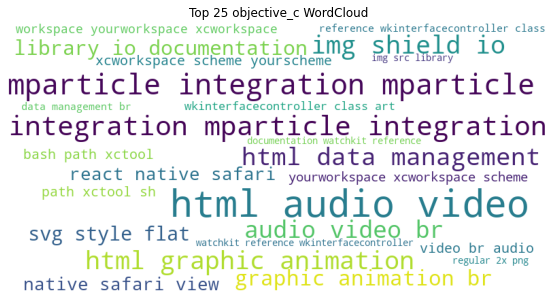

In [13]:
e.word_cloud(objective_c_25, 'objective_c')

### Takeaways:
- Objective-C programming is the primary language used for writing OSX and iOS programs for apple devices.
- Words that have a strong relationship with predicting the Objective-C languagre  are `html`, `audio`, `video`, `integration`, `graphic & animation`. 

---

## Python

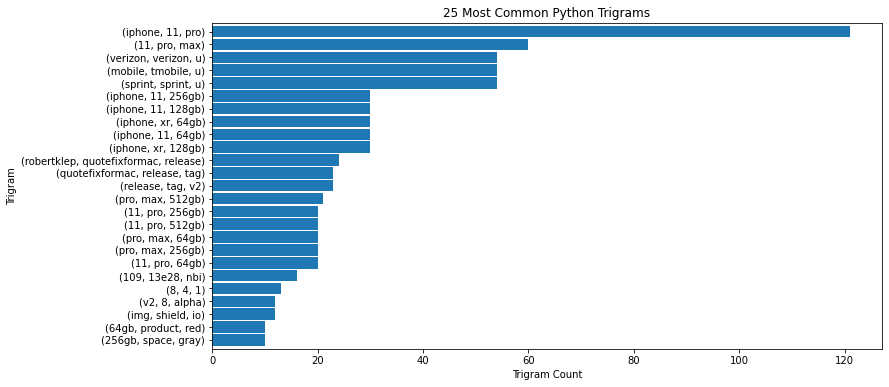

In [14]:
e.get_graph(python_25, 'Python')

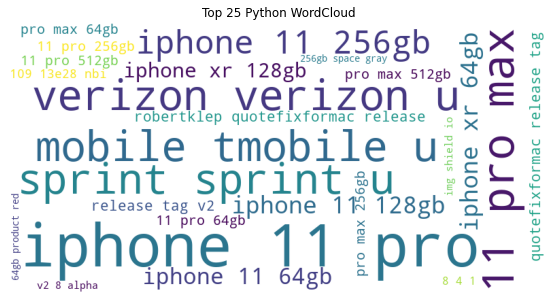

In [15]:
e.word_cloud(python_25, 'Python')

### Takeaways:

- The data provided in the first 50 pages of the `apple` search for the `python` programming language potentially do not provide results that may properly predict python. 

---

## Java

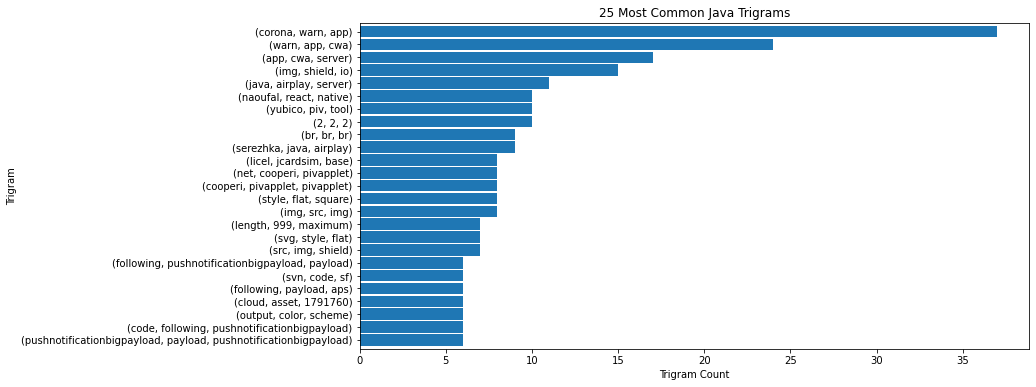

In [16]:
e.get_graph(java_25, 'Java')

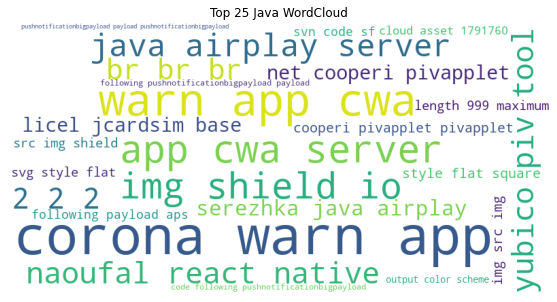

In [17]:
e.word_cloud(java_25, 'Java')

### Takeaways:

- Words like `app`, `svg`, `react`, `shield io` are the most used words in the dataframe that could potentially predict the Java language. 
- Developers use Java to construct applications in laptops, data centres, game consoles, scientific supercomputers, cell phones, and other devices. 

---

## C

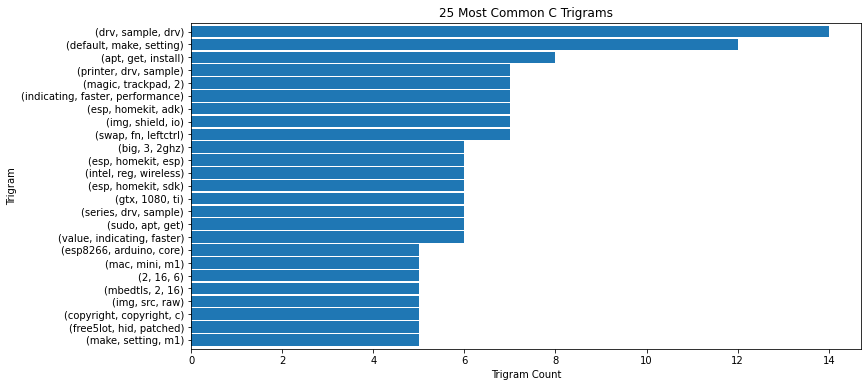

In [18]:
e.get_graph(c_25, 'C')

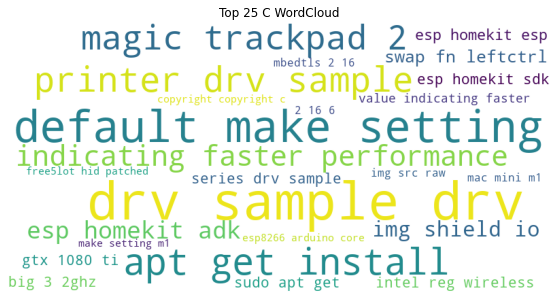

In [19]:
e.word_cloud(c_25, 'C')

### Takeaways:

- Words such as `series`, `trackpad`, `Src`, & `drv` are potentially some of the major key words in defining the `C programming language`
- The C programming language is mainly used for creating applications on the windos OS, so it might be helpful to identifty words from there. 

## Exploration Summary

During the exploration we identified the most frequent words per programming language.

#### Swift
`Style`, `IMG` , `Shield IO`, and `SRV & SVC`

#### JavaScript
`Open Source` , `Freeware` , `Software`
    

#### Objective-C
`HTML`, `Audio`, `Video` , `Integration`, `Graphic & Animation`

#### Python
`Python language was very case specific as none of the words defined pythonic language`

#### Java
`APP`, `SVG`, `REACT`, `Shield IO`

#### C
`Series`, `Trackpad`,`SRC`,`DRV`

#### Many of the languages key words overlap for two primary reasons:
- Swift, Objective-C, and C are all a part of the C programming langauge family, and as such they have many of the same terms used while in use.

#### Other languages focused in additional exploration but not covered here are:

- C++ programming language
- Shell programming language
- PHP programming language
- C# programming language

The reason as to why they were left out of the final edition of this project is because we wanted to focus in on the MVP for this project. Our MVP is defined as, in our current sample size, the languages that provided the most results. 

---

## The MVP

Our MVP was creating a model that could accuratly predict the use of the following languages:

- Swift
- JavaScript
- Objective-C
- Python
- Java
- C

In [25]:
# getting the original dataframe
model_df = m.get_original_df()

In [26]:
# getting the mvp
model_df = m.get_mvp(model_df)

### Preparing for modeling
We discovered that using a Count Vectorizer from Sklearns databased would better represent our data.

In [27]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(model_df.lemmatized)

This would return us a dataframe where we could view the vectorized counts as we move forward into our classification model:

In [28]:
pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names()).head()

,00,000,0000,000000,00000002,000035590,0001,0008,000cea19598d10ff619c5c8565bc01,001,...,zwift,zx2c4,zxvf,zxystd,zybuluo,zypper,zythum,zzanehip,zzpiglet,zzzzbh
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Setting the Count Vectorizer

In [38]:
cv = CountVectorizer()
X = cv.fit_transform(model_df.lemmatized)
y = model_df.language

# Modeling

For our modeling, we used and array of classification models to deicde which one best fit our data and would return the best results.


We also split the data to `75% Training Data` or 'In-Sample' data, and `25% Test Data` or 'Out-of-Sample' data.

#### The models we used were:
- Decision Tree Classifier Model
- Random Forest Model
- K Nearest Neighbor (KNN) Model

Below is the code used to represent each model: 

### Random Forest

In [48]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.25,random_state=12)

rf = RandomForestClassifier(max_depth=5)

rf.fit(X_train_2, y_train_2)

y_pred = rf.predict(X_train_2)

y_pred_proba = rf.predict_proba(X_train_2)

### KNN

In [49]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=.25, random_state=12)

# knn object
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# fit
knn.fit(X_train_3, y_train_3)
# make predictions
y_pred = knn.predict(X_train)
# estimate probability
y_pred_proba = knn.predict_proba(X_train)

### Decision Tree:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.25, 
                                                   random_state=123)

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

tree.score(X_train, y_train)

train_pred = (tree.predict(X_train) ==y_train).mean()

### The best forming model was the `Decision Tree Classifier Model`:

In [53]:
train_pred

0.6755555555555556

#### The Decision Tree Model could accurately predict the use of a language with `67%` accuracy on in-sample data.

In [54]:
tree.score(X_test, y_test)

0.5333333333333333

#### On Out-of-Sample data, the model could accurately predict the use of a language with 53% accuracy. 

---

# In Conclusion:

After scraping GitHub repositories while using the keyword 'Apple', we discovered the most frequent keywords used across 22 different programming languages. We then created a model desgined around the top 6 most used languages in our sample data that could predict the use of those languages based on their keywords and features with 53% accuracy. 

## Recommendations:
_We have no recommendations at this time as this is primarily a analytical project._

## With More Time (Next Steps):
With more time we would like to:
- Pull a larger sample.
- Conduct more feature engineering on stopwords. 

### END